# Exercise 01

In [1]:
import re
import csv

# Regular expression pattern
pattern = re.compile(r"""
    ^(?P<id>\d{5})\s+
    (?P<from>\d{8})\s+
    (?P<to>\d{8})\s+
    (?P<height>\d+)\s+
    (?P<geo_width>-?\d+\.\d+)\s+
    (?P<geo_length>-?\d+\.\d+)\s+
    (?P<name>[^\d]+?)\s{2,}
    (?P<state>\S+)
""", re.VERBOSE)

lines = []
with open('data03/zehn_min_rr_Beschreibung_Stationen.txt', 'r', encoding='utf8', errors='ignore') as file:
    for line in file:
        lines.append(line.strip())

with open("data03/data_stations.csv", "w", newline="") as csvfile:
    fieldnames = 'id;from;to;height;geo_width;geo_length;name;state'.split(';')
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for line in lines[1:]:
        match = pattern.match(line)
        if match:
            writer.writerow(match.groupdict())

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import load
import scipy.interpolate as interp

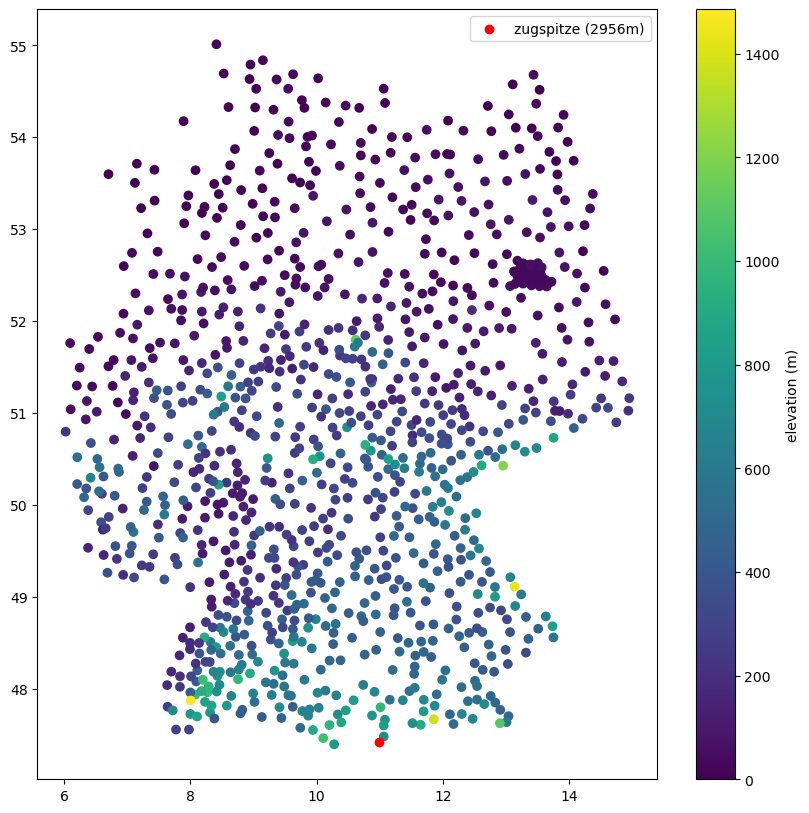

In [3]:
df = pd.read_csv('data03/data_stations.csv')
df['id'] = df['id'].astype(np.int64)

zugspitze = df[df['height']>2000]
df = df[df['height'] < 2000]

fig, ax = plt.subplots(figsize=(10, 10))
f = ax.scatter(df['geo_length'], df['geo_width'], c=df['height'], vmin=df['height'].min(), vmax=df['height'].max())
ax.scatter(zugspitze['geo_length'], zugspitze['geo_width'], c='red', label='zugspitze (2956m)')
ax.legend()

cbar = fig.colorbar(f, label='elevation (m)')

In [4]:
df_rain = pd.read_csv('data03/10min_processed.csv')
df_rain = df_rain.astype({'stationid':np.int32, 'date':str, 'rain':np.float64})
df_rain['date'] = pd.to_datetime(df_rain['date'], format="%Y%m%d%H%M")
df_rain['hour'] = df_rain['date'].map(lambda x: x.hour)
df_rain['minute'] = df_rain['date'].map(lambda x: x.minute)
df_rain['rain'] = df_rain['rain'].replace(-999.0, np.nan) 
df_rain

rain_sums = df_rain.groupby('stationid')['rain'].sum().reset_index()
rain_sums.columns = ['id', 'rain_sum']

station_hourly_rain = df_rain.groupby(['stationid', 'hour'])['rain'].sum().reset_index()
station_hourly_pivot = station_hourly_rain.pivot(index='stationid', columns='hour', values='rain')
station_hourly_pivot.columns = [f'hour_{int(col)}' for col in station_hourly_pivot.columns]
station_hourly_pivot = station_hourly_pivot.reset_index()
df_station_hours_rain = pd.merge(rain_sums, station_hourly_pivot, left_on='id', right_on='stationid').drop(columns='stationid')
df_final = pd.merge(df, df_station_hours_rain, left_on='id', right_on='id').fillna(0)
df_final

,id,from,to,height,geo_width,geo_length,name,state,rain_sum,hour_0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,44,20070208,20240422,44,52.9336,8.2370,Groenkneten,Niedersachsen,5.51,0.00,...,1.29,0.40,0.00,0.0,0.00,2.65,0.11,0.00,0.00,0.00
1,53,20050831,20240422,60,52.5850,13.5634,Ahrensfelde,Brandenburg,2.61,1.16,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,73,20070213,20240422,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern,5.97,0.00,...,1.43,0.00,0.00,0.0,0.23,0.00,0.00,0.00,0.00,0.00
3,78,20041010,20240422,64,52.4853,7.9125,Alfhausen,Niedersachsen,5.44,0.00,...,0.92,0.16,0.00,0.0,0.01,2.77,0.05,0.00,0.00,0.00
4,87,20041019,20240422,158,51.0950,11.0479,Alperstedt,Thringen,1.68,0.33,...,0.00,0.00,0.00,0.9,0.01,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,19172,20200820,20240422,48,54.0246,9.3880,Wacken,Schleswig-Holstein,1.69,0.00,...,0.00,0.00,0.00,0.0,0.00,0.23,0.00,0.41,0.59,0.46
1042,19207,20230330,20240422,16,53.8178,12.0645,Glzow-Przen,Mecklenburg-Vorpommern,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1043,19299,20210322,20240422,463,49.8713,11.7883,Speichersdorf,Bayern,6.46,0.31,...,0.27,0.14,0.08,0.0,0.00,0.00,0.00,0.29,0.14,0.66
1044,19897,20231231,20240422,37,52.5040,13.4550,Berlin-Friedrichshain-Nord,Berlin,1.90,0.90,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


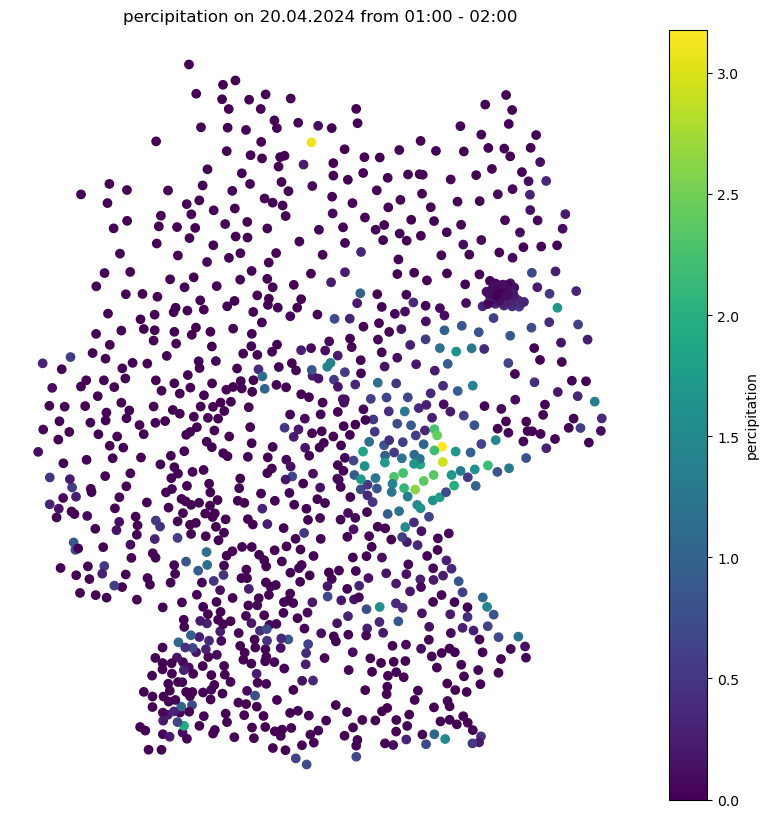

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
f = ax.scatter(df_final['geo_length'], df_final['geo_width'], c=df_final['hour_2'], vmin=df_final['hour_2'].min(), vmax=df_final['hour_2'].max())
ax.set_title('percipitation on 20.04.2024 from 01:00 - 02:00')
ax.axis('off')
cbar = fig.colorbar(f, label='percipitation')

In [6]:
data = load('data03/griddata.npz')
geolat = data['geolat']
geolong = data['geolong']
ind = data['ind']
del data

In [7]:
print(geolat.shape)
print(geolong.shape)
print(ind.shape)

(100, 100)
(100, 100)
(100, 100)


In [8]:
interp_points = []
for i in range(100):
    for j in range(100):
        if ind[i][j]:
            interp_points.append([geolong[0][j], geolat[i][0]])
grid = np.array(interp_points)
sample_points = np.array(df_final[['geo_length', 'geo_width']])

In [9]:
def fill_and_reshape(xs):
    index = 0
    res = []
    for i in range(100):
        for j in range(100):
            if ind[i][j]:
                res.append(xs[index])
                index += 1
            else:
                res.append(np.nan)
    return np.flipud((np.array(res)).reshape(100,100))
                

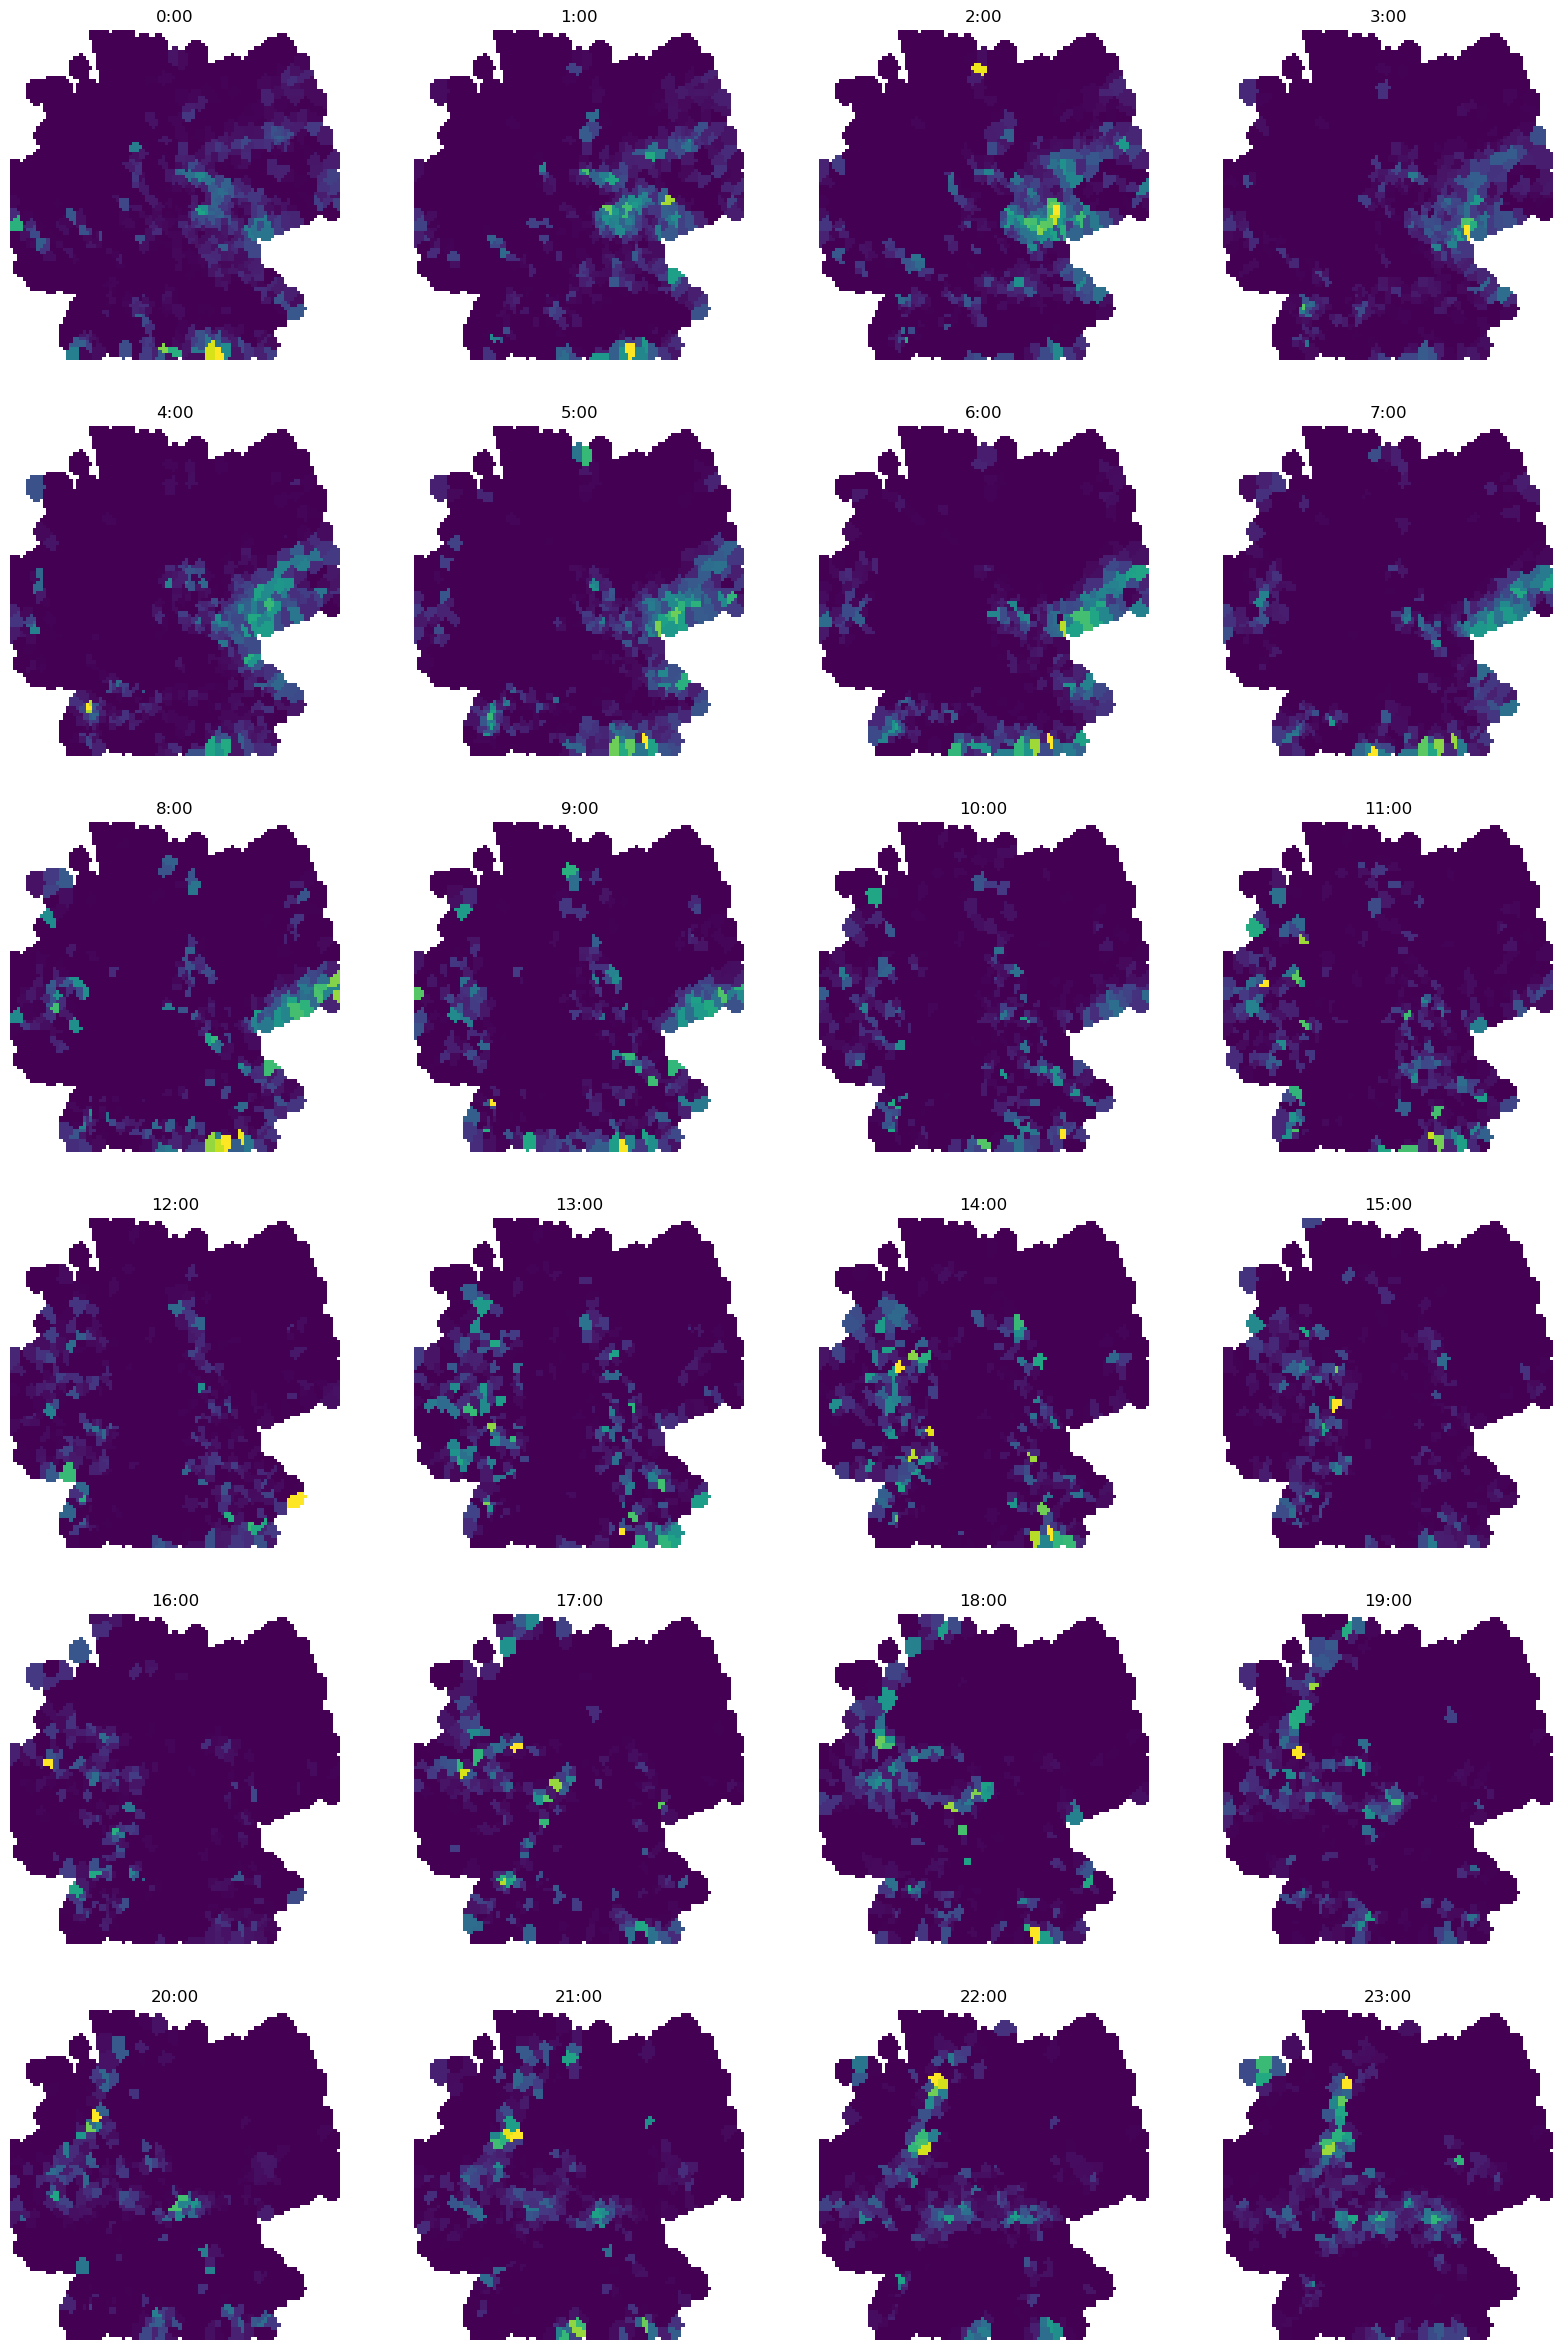

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(20, 30))
for h in range(24):
    axi = ax[h // 4][h % 4]
    values = np.array(df_final[f'hour_{int(h)}'])
    res = interp.griddata(sample_points, values, grid, method='nearest')
    res = fill_and_reshape(res)
    axi.imshow(res, cmap='viridis')
    axi.set_title(f'{h}:00')
    axi.axis('off')
plt.show()

# Exercise 02

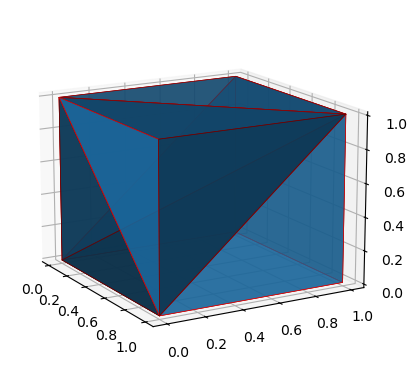

In [4]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def simplex2triangles(sx):
    return np.array([
      [sx[0], sx[1], sx[2]],  
      [sx[0], sx[1], sx[3]],  
      [sx[0], sx[2], sx[3]],  
      [sx[1], sx[2], sx[3]]  
    ])

points = np.array([
    [0,0,0],
    [0,1,0],
    [0,1,1],
    [0,0,1],
    [1,0,0],
    [1,1,0],
    [1,1,1],
    [1,0,1]
  ],dtype=np.double)


tri = Delaunay(points)
tetrahedra = tri.simplices
triangles = np.vstack(np.apply_along_axis(simplex2triangles, 1, tri.simplices))
triangles = np.unique(triangles, axis = 0)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

ax = plt.axes(projection='3d')
ax.view_init(15, -30)
ax.plot_trisurf(x, y, z, triangles = triangles, 
    linewidth=0.5, linewidths=1, edgecolors='r', alpha=.70, antialiased=True)


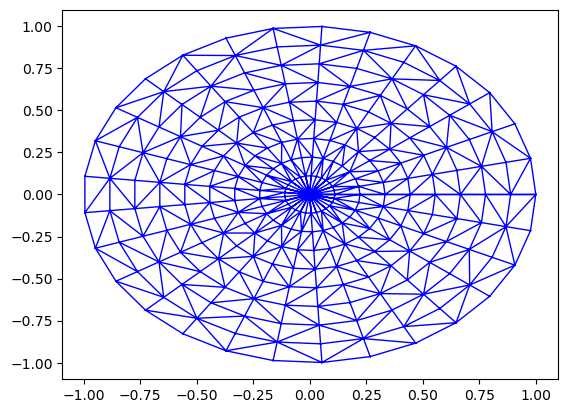

In [5]:
theta = np.linspace(0, 2 * np.pi, 30)
w = np.linspace(0, 1, 10)
w, theta = np.meshgrid(w, theta)
tri = matplotlib.tri.Triangulation(np.ravel(w), np.ravel(theta))

phi = theta * 0.5
x = np.ravel(w * np.cos(theta))
y = np.ravel(w * np.sin(theta))

ax = plt.axes()
ax.triplot(x,y, triangles=tri.triangles,color="b",lw=1)

In [6]:
%matplotlib inline

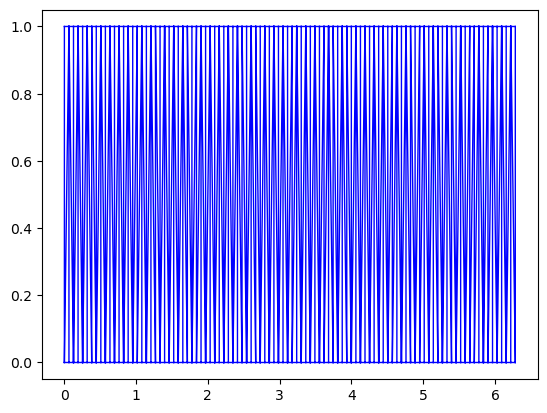

In [7]:
fig, ax = plt.subplots()
theta = np.linspace(0, 2 * np.pi, 100)
w = np.linspace(0, 1, 2)
w, theta = np.meshgrid(theta, w)
tri = matplotlib.tri.Triangulation(np.ravel(w), np.ravel(theta))

ax.triplot(tri,color="b",lw=1)

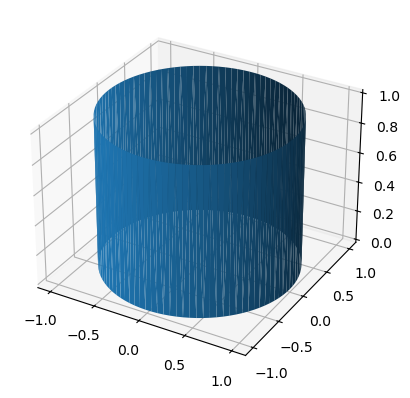

In [11]:
phi = 0.5 * theta
r = 1
x = np.ravel(np.cos(w))
y = np.ravel(np.sin(w))
z = np.ravel(theta)

ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles)
plt.show()